In [ ]:
import os, cv2, json, math
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler

In [ ]:
# === 경로 설정 ===
img_dir = "/content/drive/MyDrive/bee/data/images"
json_dir = "/content/drive/MyDrive/bee/data/jsons"
label_dir = "/content/drive/MyDrive/bee/data/labels_single"

os.makedirs(label_dir, exist_ok=True)

# === 클래스 정의 ===
class_names = ["bee"]

INPUT_SIZE = 416
S = 13
# ANCHORS = [(1.08,1.19),(3.42,4.41),(6.63,11.38),(9.42,5.11),(16.62,10.52)]  # YOLOv2 기본
ANCHORS_GRID = ((1.08,1.19),(3.42,4.41),(6.63,11.38),(9.42,5.11),(16.62,10.52))

def to_pixel_anchors(anchors_grid, input_size=INPUT_SIZE, S=S):
    cell = input_size / S
    return tuple((aw*cell, ah*cell) for aw, ah in anchors_grid)

ANCHORS_PIX = to_pixel_anchors(ANCHORS_GRID, input_size=INPUT_SIZE, S=S)

NUM_CLASSES = len(class_names)
A = len(ANCHORS_GRID)

In [ ]:
# 1. YOLOv2 모델 정의 (PyTorch)

class YOLOv2(nn.Module):
    def __init__(self, num_classes=1, anchors=5):
        super(YOLOv2, self).__init__()
        self.num_classes = num_classes
        self.anchors = anchors
        self.output_channels = (5 + num_classes) * anchors  # 5 = tx, ty, tw, th, objectness

        def conv_block(in_c, out_c, k, s, p):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.1)
            )

        self.backbone = nn.Sequential(
            conv_block(3, 32, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            conv_block(32, 64, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            conv_block(64, 128, 3, 1, 1),
            conv_block(128, 64, 1, 1, 0),
            conv_block(64, 128, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            conv_block(128, 256, 3, 1, 1),
            conv_block(256, 128, 1, 1, 0),
            conv_block(128, 256, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            conv_block(256, 512, 3, 1, 1),
            conv_block(512, 256, 1, 1, 0),
            conv_block(256, 512, 3, 1, 1),
            conv_block(512, 256, 1, 1, 0),
            conv_block(256, 512, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            conv_block(512, 1024, 3, 1, 1),
            conv_block(1024, 512, 1, 1, 0),
            conv_block(512, 1024, 3, 1, 1),
            conv_block(1024, 512, 1, 1, 0),
            conv_block(512, 1024, 3, 1, 1),
        )

        self.detector = nn.Conv2d(1024, self.output_channels, kernel_size=1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.detector(x)
        return x


In [ ]:
# 2. Dataset + Collate

class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, input_size=416):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.input_size = input_size
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_file)
        label_path = os.path.join(self.label_dir, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))

        img = cv2.imread(img_path)
        img = cv2.resize(img, (self.input_size, self.input_size))
        img = img[:, :, ::-1]  # BGR to RGB
        img = img / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1).float()

        targets = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    cls, x, y, w, h = map(float, line.strip().split())
                    targets.append([cls, x, y, w, h])
        targets = torch.tensor(targets)

        return img, targets


def yolo_collate_fn(batch):
    imgs, targets = zip(*batch)
    imgs = torch.stack(imgs, dim=0)
    return imgs, list(targets)


In [ ]:
# ===================== 여기부터 경로/설정 맞춰주세요 =====================
INPUT_SIZE = 416
images_dir_val = "/content/drive/MyDrive/bee/data/images_val"         # 🔁 본인 이미지/val 경로
labels_dir_val = "/content/drive/MyDrive/bee/data/labels_val"      # 🔁 앞서 만든 단일클래스 라벨 경로

# 3) val_dataset / val_loader 생성
val_dataset = YOLODataset(images_dir_val, labels_dir_val, input_size=INPUT_SIZE)
val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=yolo_collate_fn,
    num_workers=2,
    pin_memory=True
)

print("len(val_dataset) =", len(val_dataset))
print("len(val_loader)  =", len(val_loader))

len(val_dataset) = 17
len(val_loader)  = 3


In [ ]:
def bbox_iou_xyxy(box1, box2, eps=1e-9):
    device = box1.device
    box2 = box2.to(device)

    N, M = box1.size(0), box2.size(0)
    b1 = box1.unsqueeze(1).expand(N, M, 4)
    b2 = box2.unsqueeze(0).expand(N, M, 4)
    inter_x1 = torch.max(b1[...,0], b2[...,0])
    inter_y1 = torch.max(b1[...,1], b2[...,1])
    inter_x2 = torch.min(b1[...,2], b2[...,2])
    inter_y2 = torch.min(b1[...,3], b2[...,3])
    inter = (inter_x2 - inter_x1).clamp(min=0) * (inter_y2 - inter_y1).clamp(min=0)
    area1 = (b1[...,2]-b1[...,0]).clamp(min=0) * (b1[...,3]-b1[...,1]).clamp(min=0)
    area2 = (b2[...,2]-b2[...,0]).clamp(min=0) * (b2[...,3]-b2[...,1]).clamp(min=0)
    return inter / (area1 + area2 - inter + eps)

class YOLOLoss(nn.Module):
    def __init__(self, anchors, S=13, num_classes=1, lambda_coord=5.0, lambda_noobj=0.5, img_size=416):
        super().__init__()
        self.S = S
        self.A = len(anchors)
        self.num_classes = num_classes
        self.img_size = img_size
        self.anchors = torch.tensor(anchors) / img_size
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        self.ce  = nn.CrossEntropyLoss(reduction='sum')

    def forward(self, predictions, targets):
        B, _, S, _ = predictions.shape
        A, C = self.A, self.num_classes
        device = predictions.device

        pred = predictions.view(B, A, 5 + C, S, S).permute(0, 1, 3, 4, 2)
        px, py, pw, ph, pc = pred[..., 0], pred[..., 1], pred[..., 2], pred[..., 3], pred[..., 4]
        pcls = pred[..., 5:]

        obj_mask = torch.zeros((B, A, S, S), dtype=torch.bool, device=device)
        txy = torch.zeros((B, A, S, S, 2), device=device)
        twh = torch.zeros((B, A, S, S, 2), device=device)
        tcls = torch.zeros((B, A, S, S), dtype=torch.long, device=device)

        anchors = self.anchors.to(device)
        eps = 1e-6

        for b in range(B):
            if targets[b] is None or len(targets[b]) == 0:
                continue

            for tgt in targets[b]:
                cls, x, y, w, h = tgt
                i = int(x * S)
                j = int(y * S)

                # 라벨 안전 처리
                w = torch.clamp(w, min=eps)
                h = torch.clamp(h, min=eps)

                gt_box = torch.tensor([x - w/2, y - h/2, x + w/2, y + h/2], device=device).unsqueeze(0)
                anchor_boxes = []
                for anchor in anchors:
                    aw, ah = anchor
                    ax1 = x - aw / 2
                    ay1 = y - ah / 2
                    ax2 = x + aw / 2
                    ay2 = y + ah / 2
                    anchor_boxes.append([ax1, ay1, ax2, ay2])
                anchor_boxes = torch.tensor(anchor_boxes, device=device)
                ious = bbox_iou_xyxy(gt_box, anchor_boxes)
                best_a = ious.argmax().item()

                obj_mask[b, best_a, j, i] = True
                txy[b, best_a, j, i, 0] = x * S - i
                txy[b, best_a, j, i, 1] = y * S - j
                twh[b, best_a, j, i, 0] = torch.log(w / (anchors[best_a][0] + eps))
                twh[b, best_a, j, i, 1] = torch.log(h / (anchors[best_a][1] + eps))
                tcls[b, best_a, j, i] = int(cls)

        try:
            # 🛡️ 모델 출력 안정화
            pw = pw.clamp(min=-10, max=10)
            ph = ph.clamp(min=-10, max=10)

            # NaN/inf 추적 로그
            if torch.isnan(pw[obj_mask]).any():
                print("📛 pw[obj_mask]에 NaN 존재")
            if torch.isnan(ph[obj_mask]).any():
                print("📛 ph[obj_mask]에 NaN 존재")
            if torch.isnan(pc[obj_mask]).any() or torch.isinf(pc[obj_mask]).any():
                print("📛 pc[obj_mask]에 NaN 또는 inf 존재")

            # 손실 계산
            coord_loss = self.lambda_coord * (
                self.mse(torch.sigmoid(px)[obj_mask], txy[..., 0][obj_mask]) +
                self.mse(torch.sigmoid(py)[obj_mask], txy[..., 1][obj_mask]) +
                self.mse(pw[obj_mask], twh[..., 0][obj_mask]) +
                self.mse(ph[obj_mask], twh[..., 1][obj_mask])
            )

            conf_loss = (
                self.bce(pc[obj_mask], torch.ones_like(pc[obj_mask])) +
                self.bce(pc[~obj_mask], torch.zeros_like(pc[~obj_mask])) * self.lambda_noobj
            )

            class_loss = torch.tensor(0., device=device)
            if C > 1:
                class_loss = self.ce(pcls[obj_mask], tcls[obj_mask])

            total_loss = coord_loss + conf_loss + class_loss

            if torch.isnan(total_loss) or torch.isinf(total_loss):
                print("🚨 NaN 또는 inf 손실 발생! 디버깅 정보:")
                print("coord_loss:", coord_loss.item())
                print("conf_loss:", conf_loss.item())
                print("class_loss:", class_loss.item())
                return torch.tensor(0.0, device=device)

        except Exception as e:
            print("❌ 예외 발생 중:", e)
            return torch.tensor(0.0, device=device)

        return total_loss / B


In [ ]:
def train(model, dataloader, criterion, optimizer, device, epochs=50, amp=True):
    scaler = GradScaler(enabled=amp)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for imgs, targets in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs = imgs.to(device, non_blocking=True)

            # targets가 리스트라면 내부 tensor들 이동
            if isinstance(targets, (list, tuple)):
                targets = [t.to(device) for t in targets]
            else:
                targets = targets.to(device)

            optimizer.zero_grad(set_to_none=True)

            with autocast(device_type='cuda', enabled=amp):
                preds = model(imgs)
                loss = criterion(preds, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}] Loss: {total_loss / len(dataloader):.4f}")


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv2(num_classes=1).to(device)

dataset = YOLODataset(
    img_dir="/content/drive/MyDrive/bee/data/images",
    label_dir="/content/drive/MyDrive/bee/data/labels_single",
    input_size=416
)

dataloader = DataLoader(
    dataset, batch_size=8, shuffle=True,
    collate_fn=yolo_collate_fn, num_workers=2, pin_memory=True
)

criterion = YOLOLoss(S=S, anchors=ANCHORS_PIX, num_classes=NUM_CLASSES, img_size=INPUT_SIZE)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)
train(model, dataloader, criterion, optimizer, device, epochs=50)

save_dir = "/content/drive/MyDrive/bee/weights"
os.makedirs(save_dir, exist_ok=True)
torch.save(model.state_dict(), "/content/drive/MyDrive/bee/weights/yolov2_bee.pth")
print("✅ 가중치 저장 완료:", os.path.join(save_dir, "yolov2_bee.pth"))

Epoch 1/50: 100%|██████████| 600/600 [19:57<00:00,  2.00s/it]


Epoch [1] Loss: 69.6097


Epoch 2/50: 100%|██████████| 600/600 [00:52<00:00, 11.38it/s]


Epoch [2] Loss: 10.6245


Epoch 3/50: 100%|██████████| 600/600 [00:52<00:00, 11.44it/s]


Epoch [3] Loss: 7.7737


Epoch 4/50: 100%|██████████| 600/600 [00:52<00:00, 11.44it/s]


Epoch [4] Loss: 6.4875


Epoch 5/50: 100%|██████████| 600/600 [00:52<00:00, 11.45it/s]


Epoch [5] Loss: 6.0409


Epoch 6/50: 100%|██████████| 600/600 [00:52<00:00, 11.37it/s]


Epoch [6] Loss: 9.8160


Epoch 7/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [7] Loss: 8.4829


Epoch 8/50: 100%|██████████| 600/600 [00:52<00:00, 11.38it/s]


Epoch [8] Loss: 8.3985


Epoch 9/50: 100%|██████████| 600/600 [00:52<00:00, 11.47it/s]


Epoch [9] Loss: 6.2479


Epoch 10/50: 100%|██████████| 600/600 [00:52<00:00, 11.45it/s]


Epoch [10] Loss: 7.1544


Epoch 11/50: 100%|██████████| 600/600 [00:52<00:00, 11.51it/s]


Epoch [11] Loss: 6.1727


Epoch 12/50: 100%|██████████| 600/600 [00:52<00:00, 11.43it/s]


Epoch [12] Loss: 6.2510


Epoch 13/50: 100%|██████████| 600/600 [00:52<00:00, 11.44it/s]


Epoch [13] Loss: 5.6846


Epoch 14/50: 100%|██████████| 600/600 [00:52<00:00, 11.46it/s]


Epoch [14] Loss: 5.4341


Epoch 15/50: 100%|██████████| 600/600 [00:52<00:00, 11.33it/s]


Epoch [15] Loss: 5.5978


Epoch 16/50: 100%|██████████| 600/600 [00:52<00:00, 11.38it/s]


Epoch [16] Loss: 5.4286


Epoch 17/50: 100%|██████████| 600/600 [00:52<00:00, 11.39it/s]


Epoch [17] Loss: 5.2159


Epoch 18/50: 100%|██████████| 600/600 [00:52<00:00, 11.42it/s]


Epoch [18] Loss: 6.0685


Epoch 19/50: 100%|██████████| 600/600 [00:52<00:00, 11.37it/s]


Epoch [19] Loss: 5.1495


Epoch 20/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [20] Loss: 5.5443


Epoch 21/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [21] Loss: 5.0115


Epoch 22/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [22] Loss: 5.1492


Epoch 23/50: 100%|██████████| 600/600 [00:51<00:00, 11.56it/s]


Epoch [23] Loss: 4.9416


Epoch 24/50: 100%|██████████| 600/600 [00:52<00:00, 11.35it/s]


Epoch [24] Loss: 5.4626


Epoch 25/50: 100%|██████████| 600/600 [00:52<00:00, 11.34it/s]


Epoch [25] Loss: 4.8218


Epoch 26/50: 100%|██████████| 600/600 [00:52<00:00, 11.42it/s]


Epoch [26] Loss: 4.7045


Epoch 27/50: 100%|██████████| 600/600 [00:52<00:00, 11.33it/s]


Epoch [27] Loss: 4.8552


Epoch 28/50: 100%|██████████| 600/600 [00:52<00:00, 11.39it/s]


Epoch [28] Loss: 4.5765


Epoch 29/50: 100%|██████████| 600/600 [00:52<00:00, 11.49it/s]


Epoch [29] Loss: 4.7667


Epoch 30/50: 100%|██████████| 600/600 [00:52<00:00, 11.36it/s]


Epoch [30] Loss: 4.4637


Epoch 31/50: 100%|██████████| 600/600 [00:52<00:00, 11.35it/s]


Epoch [31] Loss: 4.5428


Epoch 32/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [32] Loss: 4.3548


Epoch 33/50: 100%|██████████| 600/600 [00:52<00:00, 11.43it/s]


Epoch [33] Loss: 4.5768


Epoch 34/50: 100%|██████████| 600/600 [00:52<00:00, 11.43it/s]


Epoch [34] Loss: 4.4691


Epoch 35/50: 100%|██████████| 600/600 [00:52<00:00, 11.53it/s]


Epoch [35] Loss: 4.3380


Epoch 36/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [36] Loss: 4.2384


Epoch 37/50: 100%|██████████| 600/600 [00:52<00:00, 11.43it/s]


Epoch [37] Loss: 4.2073


Epoch 38/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [38] Loss: 4.3315


Epoch 39/50: 100%|██████████| 600/600 [00:52<00:00, 11.41it/s]


Epoch [39] Loss: 4.4737


Epoch 40/50: 100%|██████████| 600/600 [00:52<00:00, 11.50it/s]


Epoch [40] Loss: 4.5099


Epoch 41/50: 100%|██████████| 600/600 [00:52<00:00, 11.38it/s]


Epoch [41] Loss: 4.1408


Epoch 42/50: 100%|██████████| 600/600 [00:52<00:00, 11.39it/s]


Epoch [42] Loss: 3.9631


Epoch 43/50: 100%|██████████| 600/600 [00:52<00:00, 11.45it/s]


Epoch [43] Loss: 3.9089


Epoch 44/50: 100%|██████████| 600/600 [00:52<00:00, 11.42it/s]


Epoch [44] Loss: 3.8766


Epoch 45/50: 100%|██████████| 600/600 [00:52<00:00, 11.39it/s]


Epoch [45] Loss: 3.8318


Epoch 46/50: 100%|██████████| 600/600 [00:52<00:00, 11.47it/s]


Epoch [46] Loss: 3.7831


Epoch 47/50: 100%|██████████| 600/600 [00:52<00:00, 11.43it/s]


Epoch [47] Loss: 3.9951


Epoch 48/50: 100%|██████████| 600/600 [00:52<00:00, 11.40it/s]


Epoch [48] Loss: 3.6925


Epoch 49/50: 100%|██████████| 600/600 [00:52<00:00, 11.41it/s]


Epoch [49] Loss: 3.6206


Epoch 50/50: 100%|██████████| 600/600 [00:52<00:00, 11.47it/s]


Epoch [50] Loss: 3.6069
✅ 가중치 저장 완료: /content/drive/MyDrive/bee/weights/yolov2_bee.pth


------------------

In [ ]:
# YOLOv2: 예측 결과 시각화(정상 박스) + IoU 표기 "전체 코드"


# =======================
# 유틸 함수
# =======================
def sigmoid(x):
    return 1/(1+torch.exp(-x))

def xywh2xyxy(xywh):
    x,y,w,h = xywh[...,0], xywh[...,1], xywh[...,2], xywh[...,3]
    return torch.stack([x-w/2, y-h/2, x+w/2, y+h/2], dim=-1)

def iou_matrix(boxes1, boxes2):
    """
    boxes1: [N,4], boxes2: [M,4]  (x1,y1,x2,y2)
    return: [N,M] IoU
    """
    if boxes1.numel() == 0 or boxes2.numel() == 0:
        # 빈 입력을 받았을 때도 호환되도록 0으로 채운 행렬 반환
        N = boxes1.shape[0] if boxes1.ndim==2 else 0
        M = boxes2.shape[0] if boxes2.ndim==2 else 0
        return torch.zeros((N, M), device=boxes1.device if boxes1.numel()>0 else boxes2.device)
    N, M = boxes1.shape[0], boxes2.shape[0]
    b1 = boxes1.unsqueeze(1).expand(N, M, 4)
    b2 = boxes2.unsqueeze(0).expand(N, M, 4)
    x1 = torch.maximum(b1[...,0], b2[...,0])
    y1 = torch.maximum(b1[...,1], b2[...,1])
    x2 = torch.minimum(b1[...,2], b2[...,2])
    y2 = torch.minimum(b1[...,3], b2[...,3])
    inter = (x2-x1).clamp(min=0) * (y2-y1).clamp(min=0)
    area1 = (b1[...,2]-b1[...,0]).clamp(min=0) * (b1[...,3]-b1[...,1]).clamp(min=0)
    area2 = (b2[...,2]-b2[...,0]).clamp(min=0) * (b2[...,3]-b2[...,1]).clamp(min=0)
    return inter / (area1 + area2 - inter + 1e-6)

def nms(boxes, scores, iou_thr=0.5, topk=300):
    """
    간단한 NMS 구현 (torchvision.nms 의존성 없이 사용)
    boxes: [N,4], scores: [N]
    return: keep indices (LongTensor)
    """
    if boxes.numel() == 0:
        return torch.empty(0, dtype=torch.long, device=boxes.device)
    order = scores.argsort(descending=True)[:topk]
    keep = []
    while order.numel() > 0:
        i = order[0].item()
        keep.append(i)
        if order.numel() == 1:
            break
        ious = iou_matrix(boxes[i].unsqueeze(0), boxes[order[1:]]).squeeze(0)
        remain = torch.where(ious <= iou_thr)[0] + 1
        order = order[remain]
    return torch.tensor(keep, dtype=torch.long, device=boxes.device)

def maybe_denorm(img_tensor, mean=None, std=None):
    """
    img_tensor: [3,H,W], (x-mean)/std 형태면 역정규화. mean/std 없으면 [0,1]로 가정.
    """
    x = img_tensor.detach().cpu().float()
    if mean is not None and std is not None:
        mean = torch.tensor(mean).view(3,1,1)
        std  = torch.tensor(std).view(3,1,1)
        x = x * std + mean
    x = x.clamp(0,1).numpy().transpose(1,2,0)
    return (x*255).astype(np.uint8)

# =======================
# 앵커(그리드 → 픽셀) 변환 헬퍼 (필요시 사용)
# =======================
def to_pixel_anchors(grid_anchors, input_size=416, S=13):
    """
    grid_anchors: (aw, ah) 가 '셀 단위'로 주어졌다면 픽셀로 변환.
    예: (1.08,1.19) → (1.08*stride, 1.19*stride), stride = input_size//S
    """
    stride = input_size // S
    return [(aw*stride, ah*stride) for (aw,ah) in grid_anchors]

# =======================
# YOLOv2 디코드 (NMS 없음, 원시 박스 반환)
# =======================
def yolov2_decode(output, num_classes, anchors, input_size=416, S=13, conf_thresh=0.25):
    """
    output: [B, A*(5+C), S, S]  (YOLOv2)
    anchors: list/tuple of (aw, ah) in **pixels** for input_size (예: 416 기준)
    return: per-image Tensor [N,6] = [x1,y1,x2,y2,score,cls]
    """
    device = output.device
    B = output.size(0)
    A = len(anchors)
    C = num_classes
    stride = input_size // S

    # [B, A*(5+C), S, S] -> [B, A, 5+C, S, S] -> [B, A, S, S, 5+C]
    # out = output.view(B, A, 5 + C, S, S).permute(0,1,3,4,2).contiguous()
    if output.dim()==4 and output.shape[1] == A*(5 + C):
        # [B, A*(5+C), S, S] -> [B, A, S, S, 5+C]
        out = output.view(B, A, 5 + C, S, S).permute(0,1,3,4,2).contiguous()
    elif output.dim()==4 and output.shape[-1] == A*(5 + C):
        # [B, S, S, A*(5+C)] -> [B, A, S, S, 5+C]
        out = output.view(B, S, S, A, 5 + C).permute(0,3,1,2,4).contiguous()
    else:
        raise ValueError(f"Unexpected output shape: {tuple(output.shape)}")

    tx = out[..., 0]
    ty = out[..., 1]
    tw = out[..., 2]
    th = out[..., 3]
    tobj = out[..., 4]
    tcls = out[..., 5:]  # [B, A, S, S, C]

    # grid
    gy, gx = torch.meshgrid(torch.arange(S, device=device), torch.arange(S, device=device), indexing='ij')
    gx = gx[None, None, ...]  # [1,1,S,S]
    gy = gy[None, None, ...]  # [1,1,S,S]

    # anchors (pixels)
    anchor_w = torch.tensor([a[0] for a in anchors], device=device).view(1, A, 1, 1)
    anchor_h = torch.tensor([a[1] for a in anchors], device=device).view(1, A, 1, 1)

    # decode to pixels (on resized input space)
    bx = (torch.sigmoid(tx) + gx) * stride
    by = (torch.sigmoid(ty) + gy) * stride
    bw = (anchor_w * torch.exp(tw))
    bh = (anchor_h * torch.exp(th))

    # corners
    x1 = bx - bw / 2
    y1 = by - bh / 2
    x2 = bx + bw / 2
    y2 = by + bh / 2

    # scores
    obj = torch.sigmoid(tobj)
    cls_prob = F.softmax(tcls, dim=-1)  # YOLOv2는 softmax
    scores, labels = (obj[..., None] * cls_prob).max(dim=-1)  # [B, A, S, S]

    # 배치별 결과 텐서 조립 (NMS 없음)
    results = []
    for b in range(B):
        x1b = x1[b].reshape(-1)
        y1b = y1[b].reshape(-1)
        x2b = x2[b].reshape(-1)
        y2b = y2[b].reshape(-1)
        sb  = scores[b].reshape(-1)
        lb  = labels[b].reshape(-1)

        keep = sb > conf_thresh
        if keep.sum() == 0:
            results.append(torch.empty(0,6, device=device))
            continue

        boxes = torch.stack([x1b[keep], y1b[keep], x2b[keep], y2b[keep]], dim=-1)
        sc    = sb[keep].unsqueeze(-1)
        cls   = lb[keep].float().unsqueeze(-1)
        dets  = torch.cat([boxes, sc, cls], dim=-1)  # [N,6]
        results.append(dets)
    return results

# =======================
# GT 변환(YOLO → 픽셀 좌표)
# =======================
def yolo_gt_to_xyxy(gt_tensor, img_size):
    """
    gt_tensor: [N,5] (cls, cx, cy, w, h) in [0,1]
    img_size: int (정사각 입력 가정: INPUT_SIZE)
    return: boxes_xyxy [N,4] (pixel), classes [N]
    """
    if gt_tensor is None or len(gt_tensor)==0:
        return torch.empty(0,4), torch.empty(0, dtype=torch.long)
    cls = gt_tensor[:,0].long()
    cx  = gt_tensor[:,1] * img_size
    cy  = gt_tensor[:,2] * img_size
    w   = gt_tensor[:,3] * img_size
    h   = gt_tensor[:,4] * img_size
    xyxy = xywh2xyxy(torch.stack([cx,cy,w,h], dim=-1))
    return xyxy, cls

# =======================
# 매칭(그리디) + 시각화
# =======================
def match_and_draw(img_rgb, pred_dets, gt_boxes, iou_match_thr=0.5, class_aware=True, class_names=None):
    """
    img_rgb: uint8 RGB
    pred_dets: [Np,6] (x1,y1,x2,y2,score,cls) - tensor
    gt_boxes:  [Ng,4] tensor (픽셀 좌표)
    출력: GT(초록), Pred(빨강). 매칭된 쌍 위에 IoU 숫자 표기.
    """
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR).copy()
    H,W = img_bgr.shape[:2]

    if gt_boxes.numel() == 0 and (pred_dets is None or pred_dets.numel()==0):
        return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # draw GT (초록)
    if gt_boxes.numel() > 0:
        for (x1,y1,x2,y2) in gt_boxes.cpu().numpy():
            x1 = int(np.clip(x1,0,W-1)); y1=int(np.clip(y1,0,H-1))
            x2 = int(np.clip(x2,0,W-1)); y2=int(np.clip(y2,0,H-1))
            cv2.rectangle(img_bgr, (x1,y1), (x2,y2), (0,255,0), 2)

    # draw Pred (빨강)
    if pred_dets is not None and pred_dets.numel() > 0:
        for (x1,y1,x2,y2,score,cls) in pred_dets.cpu().numpy():
            x1 = int(np.clip(x1,0,W-1)); y1=int(np.clip(y1,0,H-1))
            x2 = int(np.clip(x2,0,W-1)); y2=int(np.clip(y2,0,H-1))
            cv2.rectangle(img_bgr, (x1,y1), (x2,y2), (0,0,255), 2)
            if class_names is not None:
                label = f"{class_names[int(cls)]}:{score:.2f}"
                cv2.putText(img_bgr, label, (x1, max(15, y1-5)),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 2, cv2.LINE_AA)

    # 매칭 및 IoU 텍스트
    if pred_dets is not None and pred_dets.numel() > 0 and gt_boxes.numel() > 0:
        p_boxes = pred_dets[:,:4]
        g_boxes = gt_boxes
        IoU = iou_matrix(p_boxes, g_boxes)  # [Np, Ng]

        # 그리디 매칭: IoU 큰 쌍부터 선택
        pairs = []
        visited_p = set(); visited_g = set()
        ious_list = []
        for pi in range(IoU.shape[0]):
            for gi in range(IoU.shape[1]):
                ious_list.append((IoU[pi,gi].item(), pi, gi))
        ious_list.sort(reverse=True, key=lambda x: x[0])

        for iou, pi, gi in ious_list:
            if iou < iou_match_thr:
                break
            if pi in visited_p or gi in visited_g:
                continue
            pairs.append((pi, gi, iou))
            visited_p.add(pi); visited_g.add(gi)

        # 각 매칭 위에 IoU 텍스트(연두색)
        for (pi, gi, iou) in pairs:
            x1,y1,x2,y2 = p_boxes[pi].cpu().numpy().astype(int)
            x1 = int(np.clip(x1,0,W-1)); y1=int(np.clip(y1,0,H-1))
            txt = f"IoU: {iou:.4f}"
            cv2.putText(img_bgr, txt, (x1, max(15,y1-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)

    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def show_grid(images, cols=3, title=None):
    n = len(images); rows = math.ceil(n/cols)
    plt.figure(figsize=(cols*5, rows*5))
    if title: plt.suptitle(title, fontsize=16)
    for i,img in enumerate(images,1):
        plt.subplot(rows, cols, i); plt.imshow(img); plt.axis('off')
    plt.tight_layout(); plt.show()

# =======================
# 통합 실행 함수 (시각화)
# =======================
@torch.no_grad()
def visualize_val_with_iou(
    model,
    val_loader,
    class_names,
    anchors,          # 반드시 '픽셀 기준' 앵커 사용 (예: 416 기준)
    input_size,
    conf_thresh=0.001,
    nms_iou=0.5,
    iou_match_thr=0.5,
    score_thr_for_draw=0.0,  # 0으로 두면 최대한 보이게
    max_images=12,
    grid_cols=3,
    denorm_mean=None,
    denorm_std=None
):
    model.eval()
    device = next(model.parameters()).device  # 모델 디바이스 추론
    shown = []
    for imgs, targets in val_loader:
        imgs = imgs.to(device).float()
        out  = model(imgs)
        # 인자 순서 주의: (output, num_classes, anchors, ...)
        dets_list = yolov2_decode(
            out,
            num_classes=len(class_names),
            anchors=anchors,
            input_size=input_size,
            S=13,
            conf_thresh=conf_thresh
        )

        for bi in range(imgs.size(0)):
            # 입력 복원(디스플레이용 RGB)
            img_rgb = maybe_denorm(imgs[bi], mean=denorm_mean, std=denorm_std)

            # class-wise NMS 1회만 수행
            dets = dets_list[bi]  # [N,6] tensor or empty
            if dets.numel() > 0:
                final = []
                for c in range(len(class_names)):
                    m = (dets[:,5].long()==c)
                    dc = dets[m]
                    if dc.numel()==0:
                        continue
                    keep = nms(dc[:,:4], dc[:,4], iou_thr=nms_iou)
                    kept = dc[keep]
                    if score_thr_for_draw > 0:
                        kept = kept[kept[:,4] >= score_thr_for_draw]
                    if kept.numel() > 0:
                        final.append(kept)
                pred = torch.cat(final, dim=0) if final else torch.empty(0,6, device=imgs.device)
            else:
                pred = torch.empty(0,6, device=imgs.device)

            # GT 변환 (YOLO 정규화 → 픽셀)
            gt_tensor = targets[bi] if isinstance(targets, (list,tuple)) else targets
            if gt_tensor is None or len(gt_tensor)==0:
                gt_boxes = torch.empty(0,4, device=imgs.device)
            else:
                gt_boxes, _ = yolo_gt_to_xyxy(gt_tensor.to(imgs.device), input_size)

            vis = match_and_draw(img_rgb, pred, gt_boxes, iou_match_thr=iou_match_thr, class_names=class_names)
            shown.append(vis)

            if len(shown) >= max_images:
                show_grid(shown, cols=grid_cols, title=f"Validation predictions (IoU shown, top {max_images})")
                return

    if shown:
        show_grid(shown, cols=grid_cols, title=f"Validation predictions (IoU shown, {len(shown)})")
    else:
        print("표시할 이미지가 없습니다.")




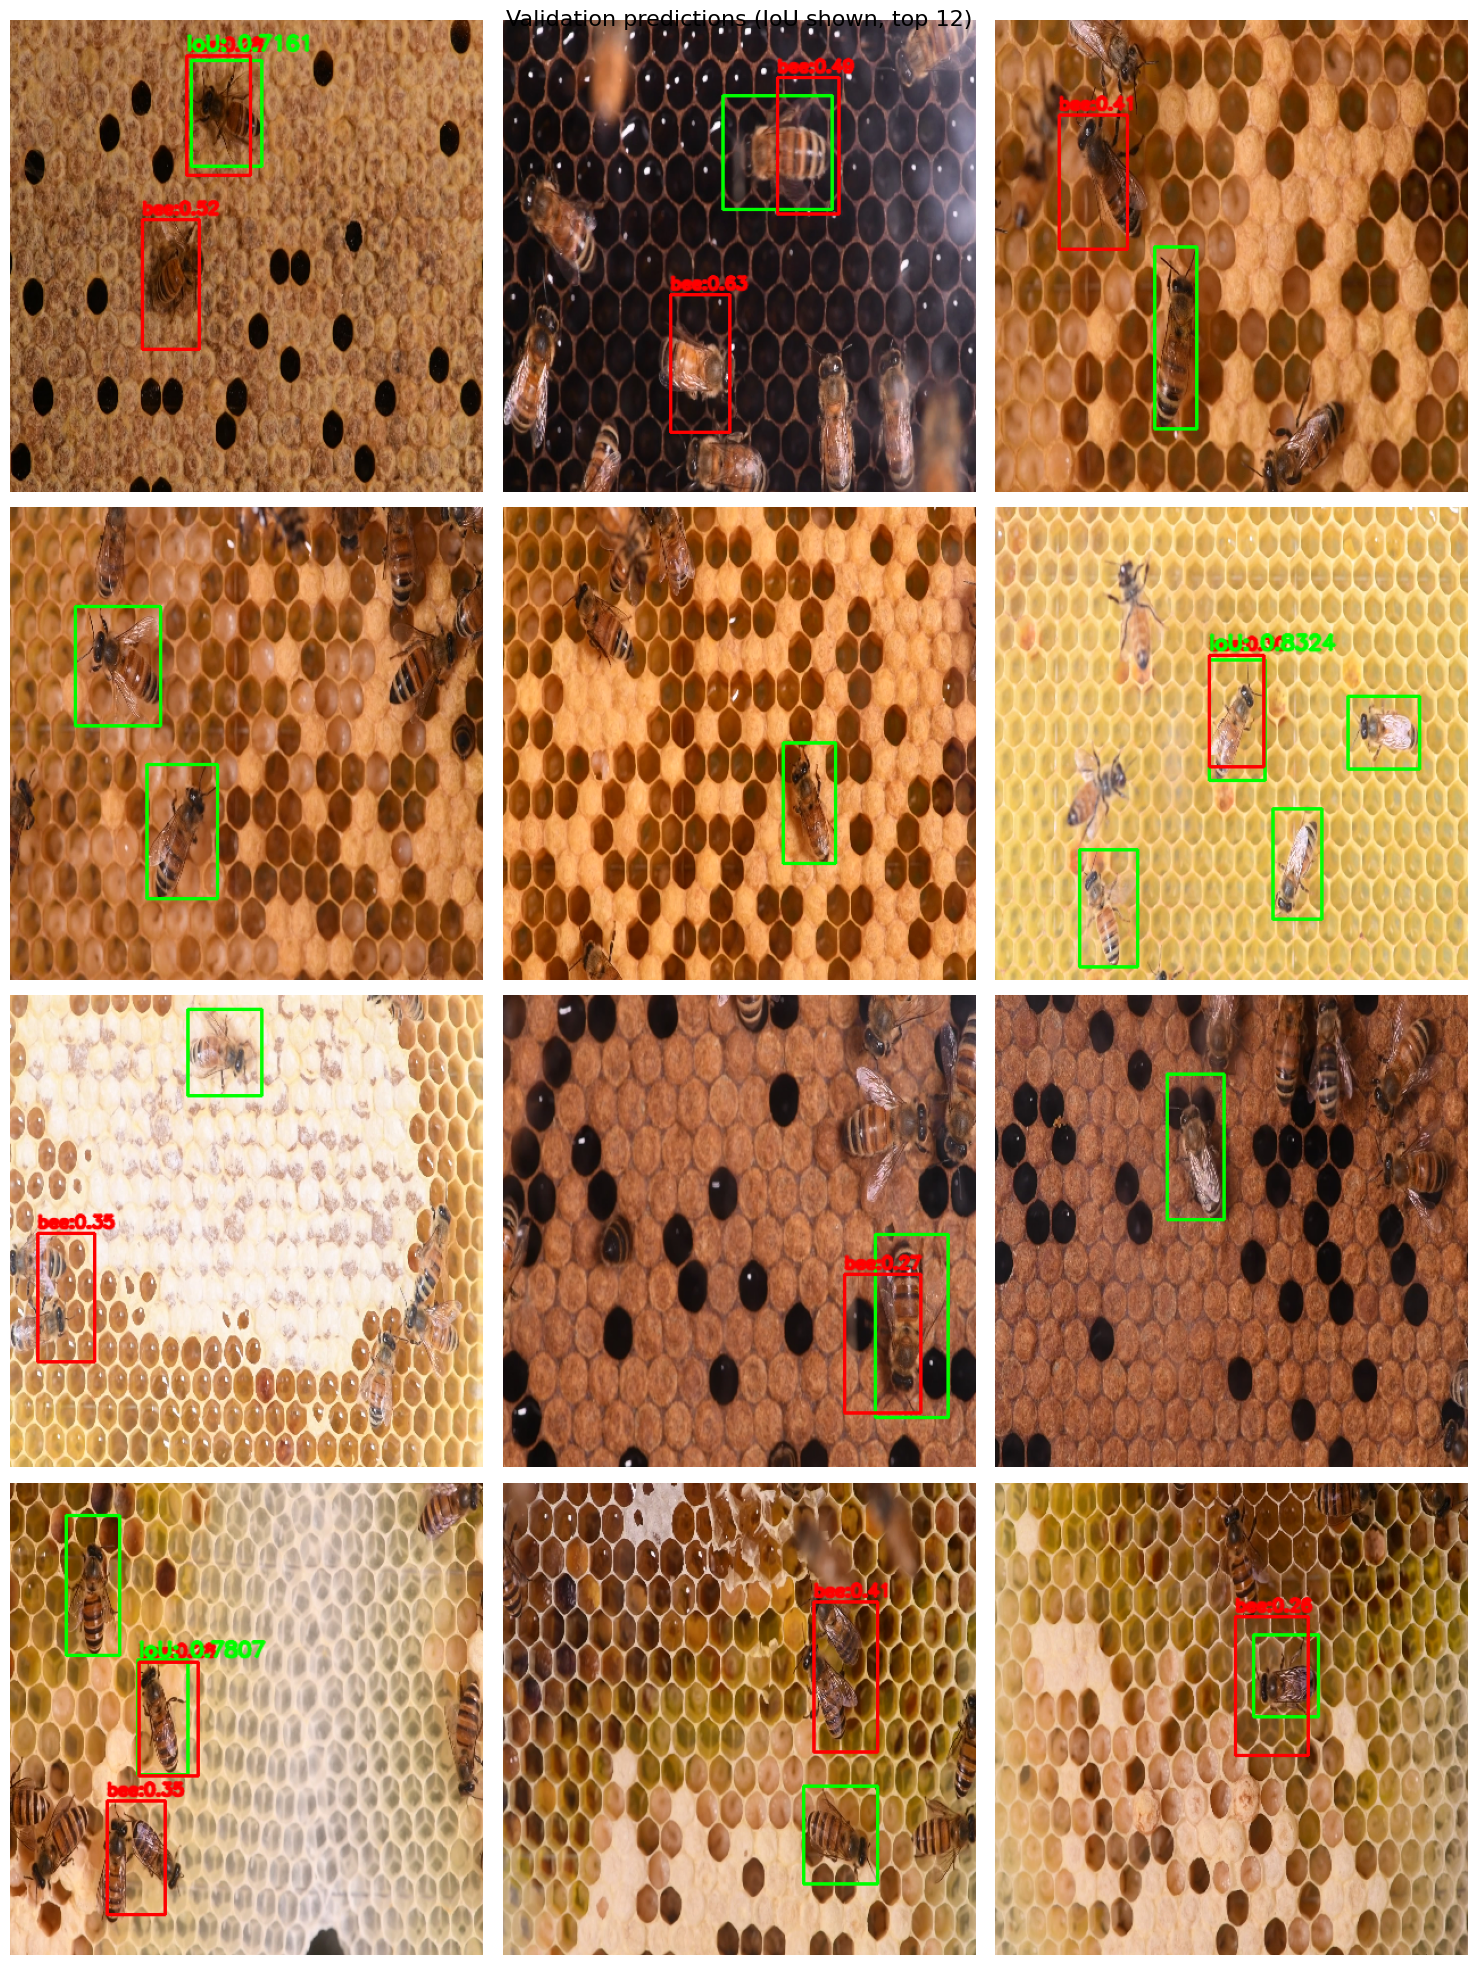

In [ ]:
# 사용 예시

INPUT_SIZE = 416
S = 13
class_names = ["bee"]  # 실제 클래스에 맞게
# 만약 그리드 단위 앵커였다면 픽셀 변환 후 사용:
# ANCHORS_GRID = ((1.08,1.19),(3.42,4.41),(6.63,11.38),(9.42,5.11),(16.62,10.52))
# ANCHORS = to_pixel_anchors(ANCHORS_GRID, input_size=INPUT_SIZE, S=S)
# 아니면 처음부터 픽셀 기준 앵커를 넣으세요: ANCHORS = ((13,13),(44,57),...)

visualize_val_with_iou(
    model,
    val_loader,
    class_names=class_names,
    # anchors=ANCHORS,
    anchors=ANCHORS_PIX,            # ← 픽셀 기준
    input_size=INPUT_SIZE,
    conf_thresh=0.25,
    nms_iou=0.5,
    iou_match_thr=0.5,
    score_thr_for_draw=0.25,
    max_images=12,
    grid_cols=3,
    denorm_mean=None,
    denorm_std=None
)

In [ ]:
# 크롭 함수

import os, cv2, math
import numpy as np

def clamp(val, lo, hi):
    return max(lo, min(hi, val))

def expand_to_square(x1, y1, x2, y2, H, W, padding_ratio=0.10):
    """bbox를 padding_ratio만큼 확장하고 정사각형으로 맞춘 뒤 이미지 경계로 클램프"""
    w = x2 - x1
    h = y2 - y1
    # 1) padding
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w2 = w * (1 + padding_ratio*2)
    h2 = h * (1 + padding_ratio*2)

    # 2) 정사각형 변환(긴 변 기준)
    side = max(w2, h2)
    nx1 = cx - side/2
    ny1 = cy - side/2
    nx2 = cx + side/2
    ny2 = cy + side/2

    # 3) 이미지 경계 클램프
    nx1 = clamp(nx1, 0, W-1)
    ny1 = clamp(ny1, 0, H-1)
    nx2 = clamp(nx2, 0, W-1)
    ny2 = clamp(ny2, 0, H-1)

    # 정수화
    return int(nx1), int(ny1), int(nx2), int(ny2)

def crop_and_resize_square(img_bgr, box, out_size=224, padding_ratio=0.10):
    """box: (x1,y1,x2,y2) 픽셀좌표. 정사각형 확장 후 224x224 리사이즈"""
    H, W = img_bgr.shape[:2]
    x1,y1,x2,y2 = box
    x1,y1,x2,y2 = expand_to_square(x1,y1,x2,y2, H,W, padding_ratio)
    crop = img_bgr[y1:y2, x1:x2]
    if crop.size == 0:
        return None
    crop = cv2.resize(crop, (out_size, out_size), interpolation=cv2.INTER_LINEAR)
    return crop, (x1,y1,x2,y2)
